In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from sklearn.metrics import classification_report
from tensorflow.keras.metrics import Precision, Recall
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
import shutil
from google.colab import drive

drive.mount('/content/drive')

local_data_dir = "/content/emotion_data"

if not os.path.exists(local_data_dir):
    print("Copying data from Google Drive to local storage...")
    shutil.copytree("/content/drive/MyDrive/Emotion Detection", local_data_dir)
    print("Copy complete!")
else:
    print("Data already copied to local storage!")

train_dir = "/content/emotion_data/train"
test_dir = "/content/emotion_data/test"

print("\nLocal train directory contents:")
print(os.listdir(train_dir))

Mounted at /content/drive
Copying data from Google Drive to local storage...
Copy complete!

Local train directory contents:
['happy', 'surprise', 'neutral', 'fear', 'disgust', 'angry', 'sad']


In [32]:
IMG_SIZE = (48, 48)
BATCH_SIZE = 128
NUM_CLASSES = 7
EPOCHS = 30

In [34]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    color_mode='grayscale',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    subset='training',
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    color_mode='grayscale',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    subset='validation',
    seed=42
)

Found 28730 files belonging to 7 classes.
Using 25857 files for training.
Found 28730 files belonging to 7 classes.
Using 2873 files for validation.


In [35]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.15),
])

In [36]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
).map(
    lambda x, y: (x/255.0, y),
    num_parallel_calls=AUTOTUNE
).cache().prefetch(AUTOTUNE)

val_ds = val_ds.map(
    lambda x, y: (x/255.0, y),
    num_parallel_calls=AUTOTUNE
).prefetch(AUTOTUNE)

In [37]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Resizing

base_model = MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

inputs = Input(shape=(48, 48, 1))
x = Concatenate()([inputs, inputs, inputs])
x = Resizing(96, 96)(x)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x * 255.0)

x = base_model(x, training=False)

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs, outputs)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [38]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy',
        Precision(name='precision'),
        Recall(name='recall')]
)

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 48, 48, 3) │          0 │ input_layer_6[0]… │
│ (Concatenate)       │                   │            │ input_layer_6[0]… │
│                     │                   │            │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 96, 96, 3) │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 96, 96, 3) │          0 │ resizing[0][0]    │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_1       │ (None, 96, 96, 3) │          0 │ multiply_1[0][0]  │
│ (TrueDivide)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_1          │ (None, 96, 96, 3) │          0 │ true_divide_1[0]… │
│ (Subtract)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_96 │ (None, 3, 3,      │  2,257,984 │ subtract_1[0][0]  │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    327,936 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 7)         │      1,799 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,588,743 (9.88 MB)

 Trainable params: 330,247 (1.26 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

In [39]:
for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)

(128, 48, 48, 1) (128, 7)


In [40]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 54s 182ms/step - accuracy: 0.1972 - loss: 2.7530 - precision: 0.2202 - recall: 0.1183 - val_accuracy: 0.3254 - val_loss: 1.8958 - val_precision: 0.4563 - val_recall: 0.1507 - learning_rate: 1.0000e-04
Epoch 2/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.2923 - loss: 2.1876 - precision: 0.3550 - recall: 0.1792 - val_accuracy: 0.3481 - val_loss: 1.8228 - val_precision: 0.4864 - val_recall: 0.1744 - learning_rate: 1.0000e-04
Epoch 3/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.3271 - loss: 2.0129 - precision: 0.4115 - recall: 0.1998 - val_accuracy: 0.3592 - val_loss: 1.7781 - val_precision: 0.5214 - val_recall: 0.1907 - learning_rate: 1.0000e-04
Epoch 4/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.3457 - loss: 1.9081 - precision: 0.4453 - recall: 0.2068 - val_accuracy: 0.3648 - val_loss: 1.7359 - val_precision: 0.5194 - val_recall: 0.2001 - learning_rate: 1.0000e-04
Epoch 5/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s

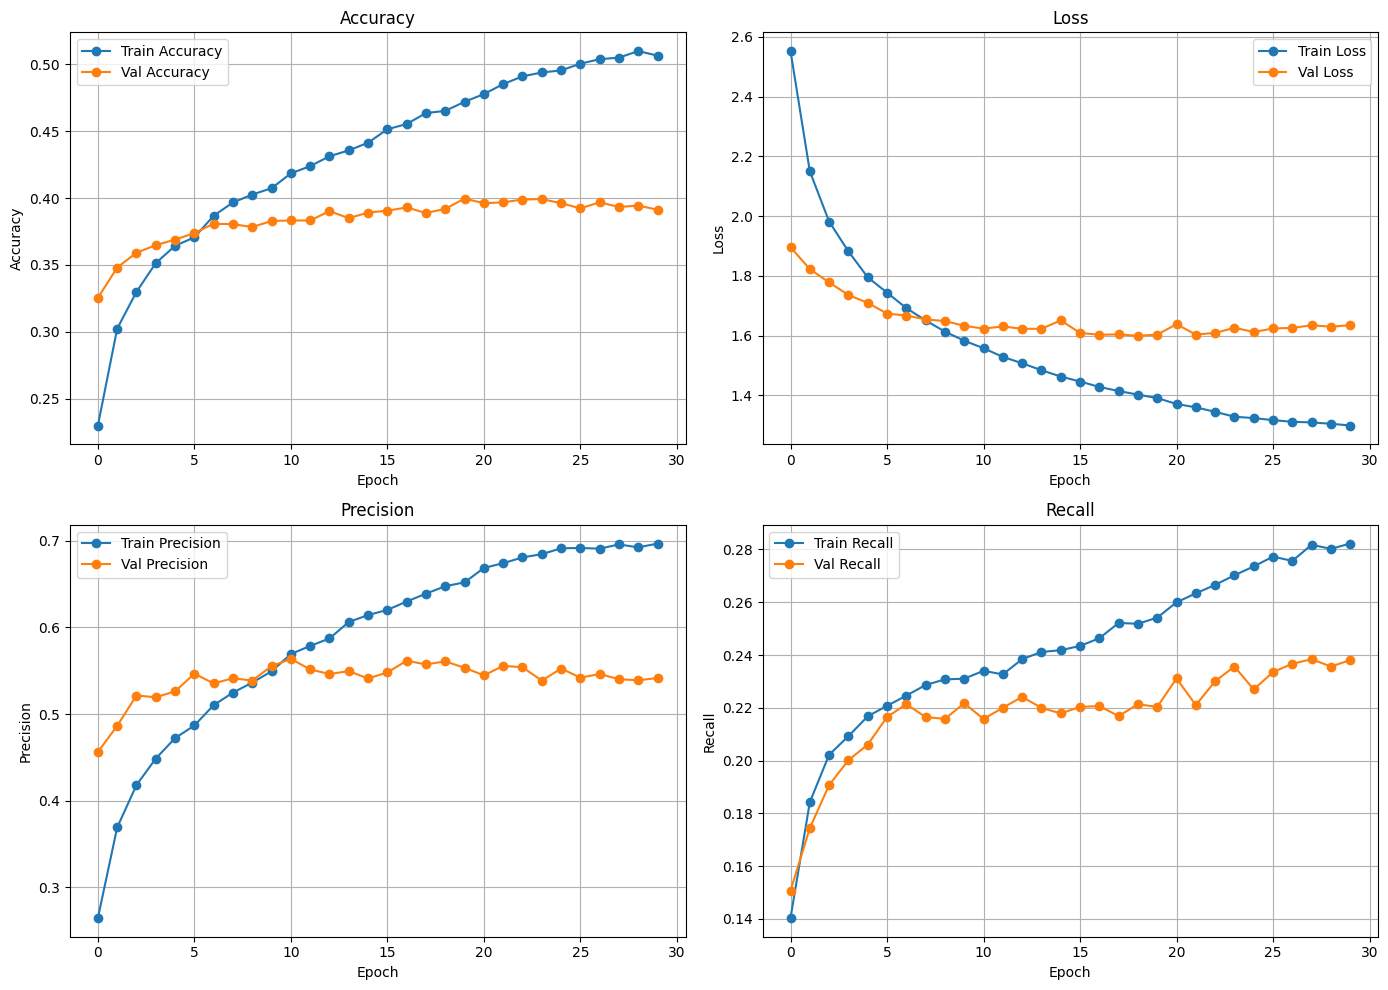

In [41]:
plt.figure(figsize=(14, 10))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

# Precision
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Train Precision', marker='o')
plt.plot(history.history['val_precision'], label='Val Precision', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Train Recall', marker='o')
plt.plot(history.history['val_recall'], label='Val Recall', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [45]:
from sklearn.metrics import classification_report
import numpy as np

try:
    class_labels = train_ds.class_names
except AttributeError:
    print("Warning: Class names attribute not found on train_ds. Using standard 7-emotion labels.")
    class_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Y_true = []
for images, labels in val_ds:
    Y_true.append(labels.numpy())
Y_true = np.concatenate(Y_true, axis=0)
y_true = np.argmax(Y_true, axis=1)

Y_pred = model.predict(val_ds, verbose=1)

y_pred = np.argmax(Y_pred, axis=1)

print('\nClassification Report')
print(classification_report(y_true, y_pred, target_names=class_labels))

23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step

Classification Report
              precision    recall  f1-score   support

       angry       0.15      0.19      0.17       384
     disgust       0.00      0.00      0.00        39
        fear       0.13      0.08      0.10       429
       happy       0.25      0.40      0.30       695
     neutral       0.18      0.16      0.17       489
         sad       0.18      0.12      0.14       489
    surprise       0.12      0.09      0.10       348

    accuracy                           0.19      2873
   macro avg       0.14      0.15      0.14      2873
weighted avg       0.17      0.19      0.18      2873



Using class labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step


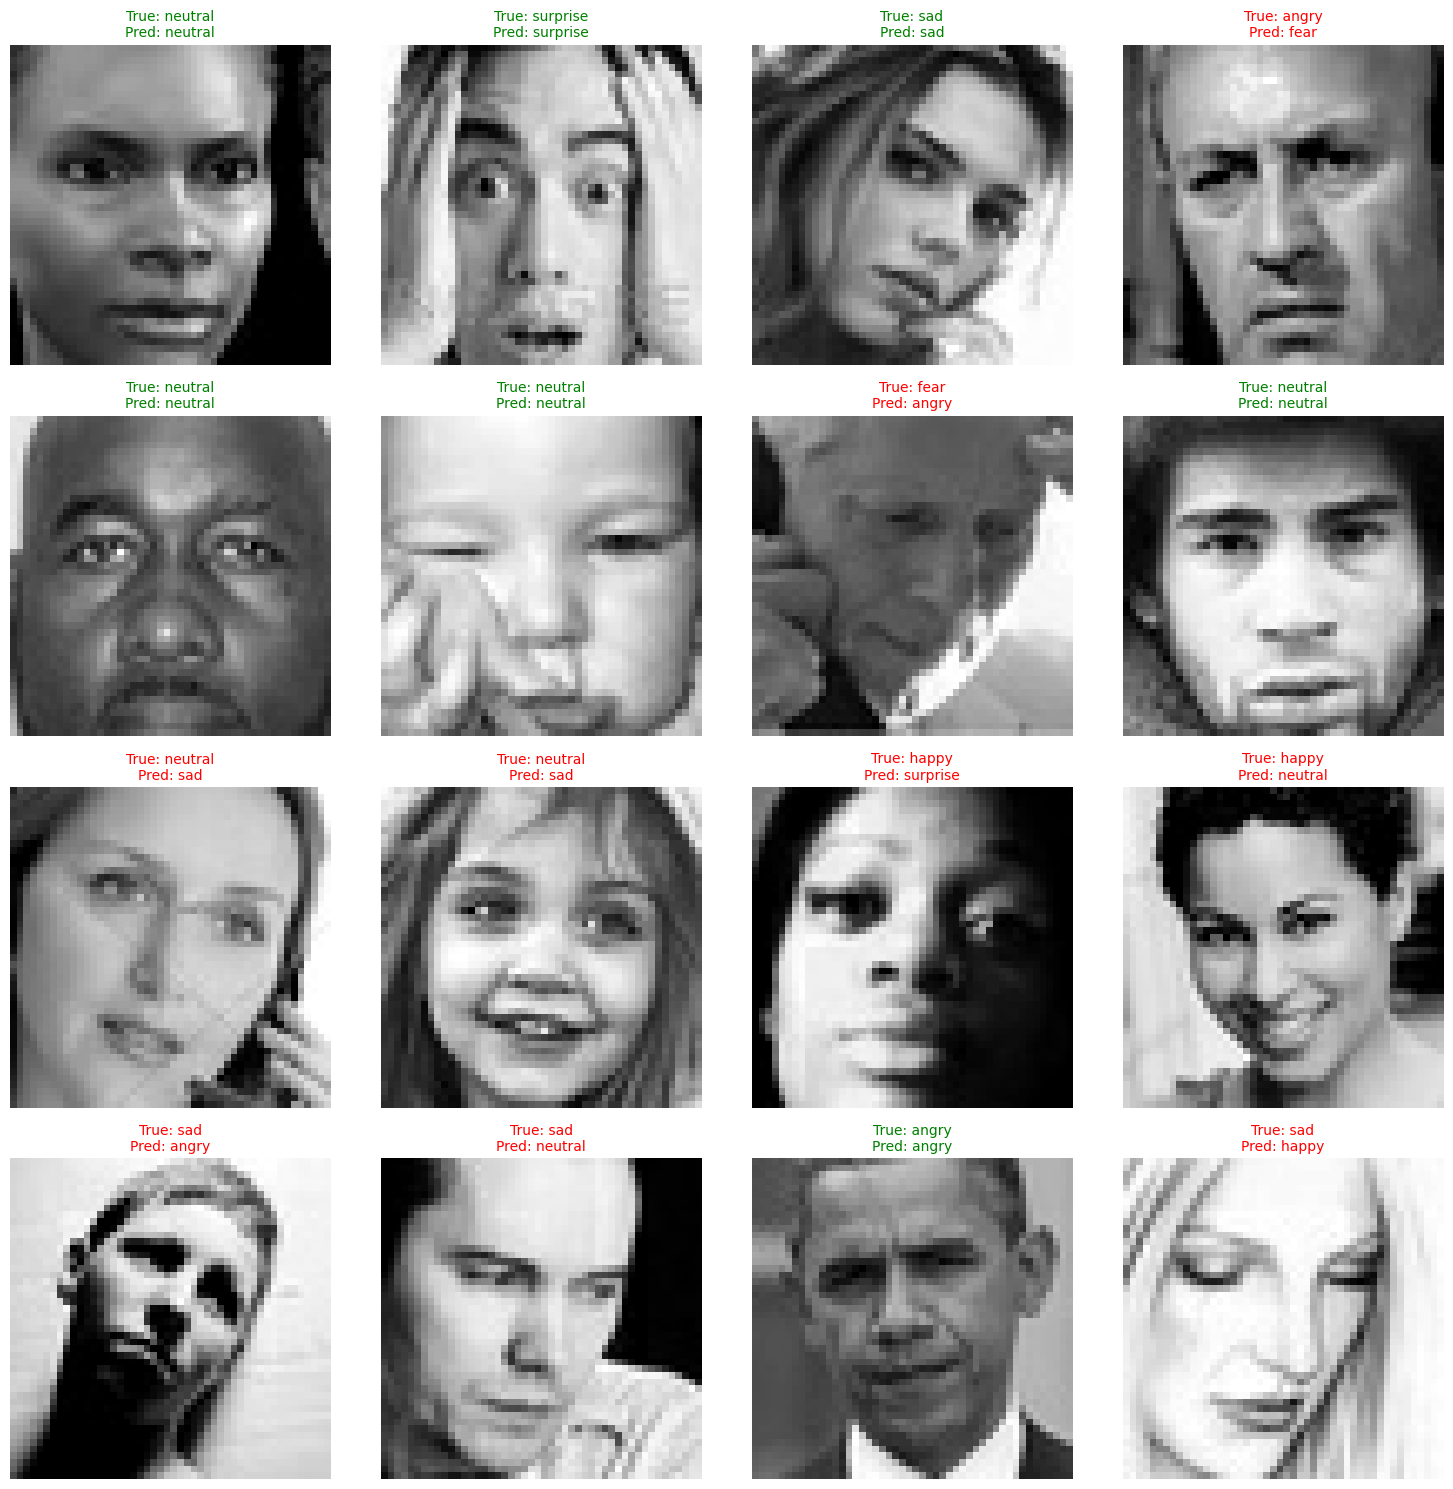

In [47]:
import numpy as np
import matplotlib.pyplot as plt

class_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
print(f"Using class labels: {class_labels}")

idx_to_class = {i: name for i, name in enumerate(class_labels)}

for images, labels in val_ds.take(1):
    X_sample = images.numpy()
    Y_sample_true = labels.numpy()
    Y_sample_pred = model.predict(X_sample)

    break

N_IMAGES_TO_PLOT = 16

plt.figure(figsize=(15, 15))
for i in range(min(N_IMAGES_TO_PLOT, X_sample.shape[0])):
    plt.subplot(4, 4, i + 1)

    true_idx = np.argmax(Y_sample_true[i])
    pred_idx = np.argmax(Y_sample_pred[i])

    true_label = idx_to_class[true_idx]
    predicted_label = idx_to_class[pred_idx]

    color = 'green' if true_label == predicted_label else 'red'

    display_image = (X_sample[i].squeeze() + 1) / 2.0
    plt.imshow(display_image, cmap='gray')

    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()